# Time series prediciton


The problem of predicting a time series is quite common in the context of neural networks. In these cases, a usual approach is to use the Recurrent Neural Networks (RNN). This family of neural networks was developed specifically for processing sequential data. Then, according to [Voelker et al.](http://compneuro.uwaterloo.ca/files/publications/voelker.2019.lmu.pdf), a variety of RNN architectures have been used not only for time series prediction but also for tasks that require learning long and short-range temporal dependencies such as machine translation, speech recognition, image caption generation, etc. A particular architecture that has been successful in modeling complex temporal relationships is the LSTM. This architecture combines memory cells and gating mechanisms that maintain and nonlinearly mix information over time [Voelker et al.](http://compneuro.uwaterloo.ca/files/publications/voelker.2019.lmu.pdf). Another possible approach for modeling the time series prediction problem is to use a fully-connected neural network (FCNN) to learn to obtain the time derivative of the series and then use a numerical integration scheme to recover the data.

In the context of videos, there is the interest of predicting the next frames of a video, particularly for autonomous cars, drones, and other robots. By predicting some events of the environment, they can anticipate changes in the near future and behave accordingly. In this context, there is the work of [Vukotić et al.](https://arxiv.org/pdf/1702.04125.pdf) that used the autoencoder architecture to predict the next frame of a video.

## Development

For the development of the time series prediction it will be used the three architectures mentioned above, the LSTM, the FCNN and a decoder to predict the next step of the frame. For each architecture it will be peformed the hyperparameter optimisation, as done for the autoencoder with the same loss function which is given by:

$$loss = \frac{\lVert y - \hat{y}\rVert_2}{\lVert y \rVert_2}$$

Also, the codes developed to perform the hyperparameter optimisation of both cases were developed to be a Python script instead of a Jupyter notebook. The hyperparameters chosen and their range for each architecture will be presented in further sections.

The codes of the hyperparameter optimisation can be found at:

1. [FCNN](./hyperparameter-optimisation/pred_fcnn_search.py);
1. [LSTM](./hyperparameter-optimisation/pred_lstm_search.py);
1. [Decoder](./hyperparameter-optimisation/pred_dec_search.py).


The further sections will be focused in present only the best archtiectures found and the ROM results for each architecture. It will be used only the dimensionality reduction from the regularised convolutional autoencoder, as it presented the best results. Furthermore, the test dataset will be obtained from the last $10$ time steps of the $14$ simulated cases.

### Preliminary steps

Import modules

In [1]:
# Python modules
import glob
import os
import joblib

# HDF5 and Scientific computing
import h5py
import numpy as np
import pandas as pd
import scipy.integrate as it

# Neural networks libraries
import tensorflow as tf
import keras.layers as layers
from keras import backend, optimizers, regularizers
from keras.models import Model, load_model
from keras.utils import plot_model

# Hyperparameter optimisation library
import optuna
from optuna.integration import KerasPruningCallback
from optuna.visualization import *

# Custom modules
from utils import plot_red_comp, slicer, split, format_data
from utils_keras import loss_norm_error, loss_norm_error_np

Using TensorFlow backend.


In [2]:
# Windows fix for pydot
import pydotplus as pyd
import keras
keras.utils.vis_utils.pydot = pyd

# Keras custom objects
from keras.utils.generic_utils import get_custom_objects

# Set custom keras functions
get_custom_objects().update({"loss_norm_error": loss_norm_error})

In [3]:
# Import plot modules
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Seaborn plot style
import seaborn as sns
sns.set()

Directories where the models are stored

In [4]:
# Architecture
arch_fcnn = "fcnn_v2"
arch_lstm = "lstm_v2"
arch_dec = "dec_v2"

# Paths to the model and Optuna study
path_model = "./hyperparameter-optimisation/models/model_pred-{}.h5"
path_study = "./hyperparameter-optimisation/models/study_{}.pkl"

# Autoencoder path
ae_conv = "smp_v4"
ae_path = "./hyperparameter-optimisation/models/model_ae-{}.h5"

Load data generated from the OpenLB

In [5]:
# Datasets to load
dt_fl = "nn_data.h5"
dt_dst = "scaled_data"

# Open data file
f = h5py.File(dt_fl, "r")
dt = f[dt_dst]

In order to obtain the reduced dimension data, it was developed a Python script that splits the autoencoder model into an encoder and decoder part and then generates the data in the lower dimension space. After generating it, the data was standardized to remove the mean and set the standard deviation to be $1$. Finally, the data was saved in a file named `data_compact.h5`. The Python script can be accessed at [script](./pre_proc_latent.py).

In [6]:
# Reduced dimensions
dt_fl_red = "data_compact.h5"
dt_dst_red = "model_ae-smp_4_scaled"

# Open data file
f_red = h5py.File(dt_fl_red, "r")
dt_red = f_red[dt_dst_red]

### FCNN

#### Search space

Architecture hyperparameters range for each layer:
* Number of layers: $l \in [1, 2]$;
* Number of neurons: $n \in [30, 150]$;
* Activation functions: $a =ReLU, \,ELU, \,Hyperbolic\,Tangent, \,Linear$;
* Regularizer: $r \in [10^{-7}, 10^{-2}]$;

Optimisation hyperparameters range:
* Batch size: $b \in [2, 32]$
* Learning rate: $r \in [10^{-5}, 10^{-1}]$;

#### Results

The script to build the FCNN in the range present above was developed and it is in the `objective()` function at the [FCNN](./hyperparameter-optimisation/pred_fcnn_search.py) file.

The number of neural networks trained was set initially to be $200$ and limited to stop after one hour of training. However, as the architectures were relatively simple the optimisation process ended after approximately $30$ minutes. Then, it was set to train $600$ more FCNN architectures and also limited to stop after one hour of training. Finally, it found the best architecture at the neural network $730$.

The best architecture hyperparameters:
* Number of layers: $l = 1$;
* $1^{st} layer$:
    * Number of neuron: $n_1 = 48$;
    * Activation function: $a_1 = Hyperbolic\, tangent$;
    * Regularization: $l_1 = 2.3538\cdot10^{-3}$
 
The best training hyperparameters:
* Batch size: $b = 30$
* Learning rate: $r = 3.5115\cdot10^{-3}$;

The schematic representation of the architecture is presented below:


Parameters to train: 8778


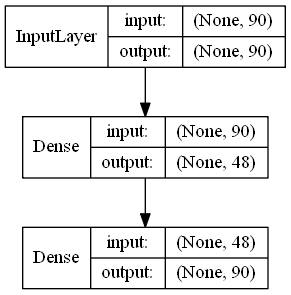

In [7]:
# Load trained model
fcnn = load_model(path_model.format(arch_fcnn))
# Get number of parameters to train
print("Parameters to train: {}".format(fcnn.count_params()))
# Generate autoencoder architecture graph
plot_model(fcnn, show_layer_names=False, show_shapes=True, dpi=96)

#### Evaluating performance

The best loss obtained during the hyperparameter optimisation was $0.8888$.

In [8]:
# Calculating the time derivatives
y_diff = np.empty_like(dt_red)
for idx in dt_red.attrs["idx"]:
    y_diff[idx[0]:idx[1]] = np.gradient(dt_red[idx[0]:idx[1]], 10, axis=0)

# Evaluate the model against all data
fcnn_global_loss = fcnn.evaluate(dt_red , y_diff)

1415/1415 [==============================] - ETA:  - ETA:  - 0s 211us/step


In [9]:
# Split data file to get the test dataset slice
idxs = split(dt_red.shape[0], 0.8, 0.1, test_last=dt_red.attrs["idx"])
slc_trn, _, slc_tst = slicer(dt_red.shape, idxs)

# Evaluate the model against the test dataset
fcnn_test_loss = fcnn.evaluate(dt_red[slc_tst] , y_diff[slc_tst])

140/140 [==============================] - ETA:  - 0s 0us/step


In [10]:
# Display the results
index = ["Entire dataset", "Test dataset"]
columns = ["MSE", "Loss"]
pd.DataFrame([fcnn_global_loss[1:], fcnn_test_loss[1:]], index=index, columns=columns)

,MSE,Loss
Entire dataset,0.002374,39.720776
Test dataset,0.006835,79.027237


Now calculating the MSE and loss with the output integrating with explicit Runge-Kutta method of order 5(4).

In [11]:
# Set the FCNN as the function to integrate
def func(t, y):
    return fcnn.predict(y[np.newaxis])[0]

fcnn_dt = []
fcnn_tst = []
# Iterating over each study case
for idx in dt_red.attrs["idx"]:
    # Iterating over each time step
    for i, j in enumerate(range(idx[0], idx[1] - 1)):
        out = it.solve_ivp(func, [10*i, 10*(i + 1)], dt_red[j])
        mse = np.mean((dt_red[j + 1] - out.y[:, -1])**2)
        loss = loss_norm_error_np(dt_red[j + 1], out.y[:, -1])
        fcnn_dt += [[mse, loss]]
        if j in slc_tst[0]:
            fcnn_tst += [[mse, loss]]

fcnn_dt = np.array(fcnn_dt)
fcnn_tst = np.array(fcnn_tst)

In [12]:
# Display the results
index = ["Entire dataset", "Test dataset"]
columns = ["MSE", "Loss"]
pd.DataFrame([fcnn_dt.mean(axis=0), fcnn_tst.mean(axis=0)], index=index, columns=columns)

,MSE,Loss
Entire dataset,0.734085,0.613884
Test dataset,1.484260,0.794560


As we can see, the performance for the test dataset degraded significantly despite regularising and using early stopping techniques during the hyperparameter optimisation. This significant difference may be related to turbulence. At the end of each simulation case, it is expected that the flows are more developed and, therefore, more turbulent. Thus, one possible explanation is that there were not enough turbulent cases for the neural network to learn. However, it is clear that after integrating using explicit Runge-Kutta method of order 5(4) the errors were considerably smaller than the time derivative errors even for the test dataset. The final output reconstruction will be discussed in the sections below and analysed if the presented errors are high or not for the decoder.

### LSTM

The LSTM networks inputs is a sequence with a time window of size $w_{t}$ and the output is the next time step. This parameter was set to be a hyperparameter as well and therefore, it was optimised.

#### Search space

Neural network input:
* Time window input: $w_{t} \in [1, 9]$;

Architecture hyperparameters range for each layer:
* LSTM layers:
    * Number of layers: $l_{lstm} \in [1, 2]$;
    * Number of neurons: $n_{lstm} \in [4, 128]$;
    * Activation functions: $a_{lstm} =ReLU, \,ELU, \,Hyperbolic\,Tangent, \,Linear$;
    * Regularizer: $r_{lstm} \in [10^{-7}, 10^{-3}]$;
    * Dropout: $d_{lstm} \in [0, 1]$;
* Dense layers:
    * Number of layers: $l_{d} \in [0, 2]$;
    * Number of neurons: $n_{d} \in [4, 128]$;
    * Activation functions: $a_{d} =ReLU, \,ELU, \,Hyperbolic\,Tangent, \,Linear$;
    * Regularizer: $r_{d} \in [10^{-7}, 10^{-3}]$;
    * Dropout: $d_{d} \in [0, 1]$.

Optimisation hyperparameters range:
* Batch size: $b \in [2, 32]$
* Learning rate: $r \in [10^{-5}, 10^{-1}]$.

#### Results

The script to build the LSTM in the range present above was developed and it is in the `objective()` function at the [LSTM](./hyperparameter-optimisation/pred_lstm_search.py) file.

The number of neural networks trained was set initially to be $200$ and limited to stop after one hour of training. However, after $1$ hour training, it stopped at the trial $71$. Then, the hyperparameter optimisation was started again with the same settings and $90$. Finally, after one hour of training, it found the best architecture at the neural network $151$ after $161$ trained neural networks.

Neural network input:
* Time window input: $w_{t} = 4$;

The best architecture hyperparameters:
* Number of LSTM layers: $l = 1$;
* $1^{st} layer$:
    * Number of neuron: $n_1 = 127$;
    * Activation function: $a_1 = Hyperbolic\, tangent$;
    * Regularization: $l_1 = 4.5841\cdot10^{-4}$
    * Dropout: $d_{1} = 0.1341$.
 
The best training hyperparameters:
* Batch size: $b = 17$
* Learning rate: $r = 8.6428\cdot10^{-4}$;

The schematic representation of the architecture is presented below:

Parameters to train: 122264


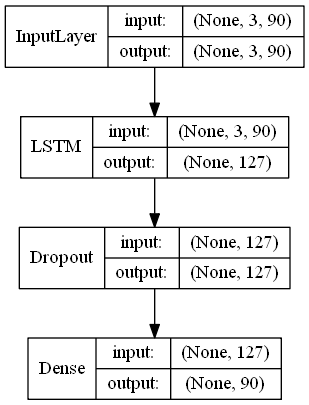

In [13]:
# Load trained model
lstm = load_model(path_model.format(arch_lstm))
# Get number of parameters to train
print("Parameters to train: {}".format(lstm.count_params()))
# Generate autoencoder architecture graph
plot_model(lstm, show_layer_names=False, show_shapes=True, dpi=96)

#### Evaluating performance

The best loss obtained during the hyperparameter optimisation was $0.4643$.

In [14]:
# LSTM window
w = 4
x_data, y_data, lstm_idx = format_data(dt_red, wd=w, get_y=True, cont=True, get_idx=True)

# Evaluate the model against all data
lstm_global_loss = lstm.evaluate(x_data, y_data)

1373/1373 [==============================] - ETA:  - ETA:  - 0s 103us/step


In [15]:
# Split data file to get the test dataset slice
idxs = split(x_data.shape[0], 0.8, 0.1, test_last=dt_red.attrs["idx"])
slc_trn, _, slc_tst = slicer(x_data.shape, idxs)

# Evaluate the model against the test dataset
lstm_test_loss = lstm.evaluate(x_data[slc_tst[0]] , y_data[slc_tst[0]])

130/130 [==============================] - ETA:  - 0s 0us/step


In [16]:
# Display the results
index = ["Entire dataset", "Test dataset"]
columns = ["MSE", "Loss"]
pd.DataFrame([lstm_global_loss[1:], lstm_test_loss[1:]], index=index, columns=columns)

,MSE,Loss
Entire dataset,0.130348,0.329235
Test dataset,0.523687,0.649877


As we can see, similarly to the FCNN, the performance for the test dataset degraded significantly despite regularising and using early stopping techniques during the hyperparameter optimisation, which reinforces the possibility that there were not enough turbulent cases for the neural network to learn. The output reconstruction will be discussed in the sections below.

### Summary of results

Finally, the it is presented in the table below the MSE and loss value of the dataset for the FCNN and LSTM both optimised neural networks.

|                    | MSE           || Loss          || Number of parameters |
|--------------------|-------|--------|-------|--------|----------------------|
|                    |**All**|**Test**|**All**|**Test**|                      |
|**FCNN**            | 0.734 |  1.484 | 0.613 |  0.794 | 8778                 |
|**LSTM**            | 0.130 |  0.523 | 0.329 |  0.649 | 122264               |

The LSTM neural network performed in all metrics presented. The most significant difference was for the MSE value for the entire dataset. It had a value of approximately $5.64$ times smaller than the FCNN, and the smaller difference was for the test dataset loss value, which was only $1.22$ times smaller. However, the LSTM is almost $14$ times larger in terms of parameters. Also, the LSTM training took considerably more computational time than the FCNN. 

Despite being better in predicting the next time step in the reduced dimensions problem, it is still required to test the differences after reconstructing the data back to the original dimensions.


## Reconstructed data

In the following codes the predicted data will be reconstructed using the FCNN, LSTM and the decoder previously trained. On the other hand, the Decoder Predictor will use only the data obtained directly from the encoder.

The first step is to split the trained autoencoder and then scale back the data to the original values.

In [17]:
# Load the autoencoder model
ae = load_model(ae_path.format(ae_conv))

# Generate the encoder
inputs = layers.Input(shape=ae.layers[0].input_shape[1:])
enc_lyr = inputs
for layer in ae.layers[1:5]:
    enc_lyr = layer(enc_lyr)
enc = Model(inputs=inputs, outputs=enc_lyr)

# Generate the decoder
inputs = layers.Input(shape=ae.layers[5].input_shape[1:])
dec_lyr = inputs
for layer in ae.layers[5:]:
    dec_lyr = layer(dec_lyr)

dec = Model(inputs=inputs, outputs=dec_lyr)

Create a function to scale and reconstruct the data back.

In [18]:
def reconstruct(x, dt_red):
    return dec.predict((x + dt_red.attrs["mean"])*dt_red.attrs["std"])

### FCNN

Integrating each dataset point with explicit Runge-Kutta method of order 5(4).

In [19]:
# Set the FCNN as the function to integrate
def func(t, y):
    return fcnn.predict(y[np.newaxis])[0]

fcnn_int = []
fcnn_idx = {}
k = 0
# Iterating over each study case
for idx in dt_red.attrs["idx"]:
    # Iterating over each time step
    for i, j in enumerate(range(idx[0], idx[1] - 1)):
        out = it.solve_ivp(func, [10*i, 10*(i + 1)], dt_red[j])
        fcnn_int += [out.y[:, -1]]
        fcnn_idx.update({j+1: k})
        k += 1

fcnn_int = np.array(fcnn_int)

Finally, reconstruct the data

In [20]:
# Reconstruct all data
fcnn_rec = reconstruct(fcnn_int, dt_red)

In [21]:
# Calculate the metrics
# Store metrics
fcnn_rec_dt = []
fcnn_rec_tst = []
# Iterating over each study case
for idx in dt.attrs["idx"]:
    # Iterating over each time step
    for i in range(idx[0], idx[1] - 1):
        if i in fcnn_idx.keys():
            mse = np.mean((dt[i] - fcnn_rec[fcnn_idx[i]])**2)
            loss = loss_norm_error_np(dt[i], fcnn_rec[fcnn_idx[i]])
            fcnn_rec_dt += [[mse, loss]]
            if i in slc_tst[0]:
                fcnn_rec_tst += [[mse, loss]]

# Convert to numpy array
fcnn_rec_dt = np.array(fcnn_rec_dt)
fcnn_rec_tst = np.array(fcnn_rec_tst)

In [22]:
# Display the results
index = ["Entire dataset", "Test dataset"]
columns = ["MSE", "Loss"]
fcnn_rec_df = pd.DataFrame([fcnn_rec_dt.mean(axis=0), fcnn_rec_tst.mean(axis=0)], index=index, columns=columns)
fcnn_rec_df

,MSE,Loss
Entire dataset,0.206257,0.460811
Test dataset,0.311367,0.491084


The MSE and loss values obtained after the reconstruction are surprisingly smaller than those obtained in the reduced dimension space. However, this result highlights an important characteristic and application of the autoencoder which is denoising. Even with small changes in the inputs, the training error, the output from the autoencoder did not changed considerably.

The visual results are presented below from the test dataset for two different study cases:

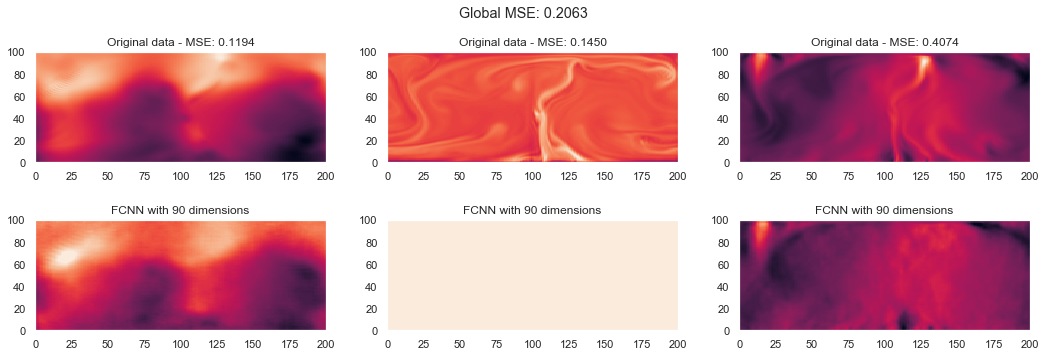

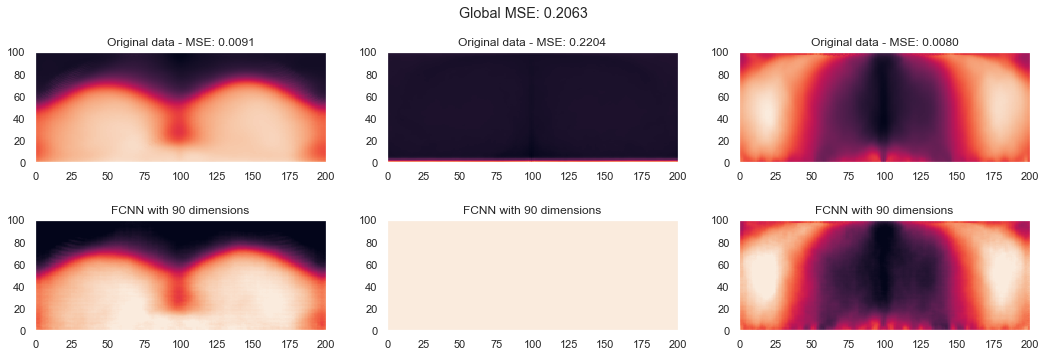

In [23]:
# Case
i = 91
# Get predicted
pred = fcnn_rec[fcnn_idx[i]]
# Get output data
real = dt[i]
# Plot
plot_red_comp(real, pred, None, 90, fcnn_rec_df['MSE'][0], "FCNN")

# Case
i = 1309
# Get predicted
pred = fcnn_rec[fcnn_idx[i]]
# Get output data
real = dt[i]
# Plot
plot_red_comp(real, pred, None, 90, fcnn_rec_df['MSE'][0], "FCNN")

From the figure above it is possible to see that the FCNN could somewhat predict the next time step both cases, especially for the second case, where there the spatial variation was lower than the first case.

A trained case is presented below.

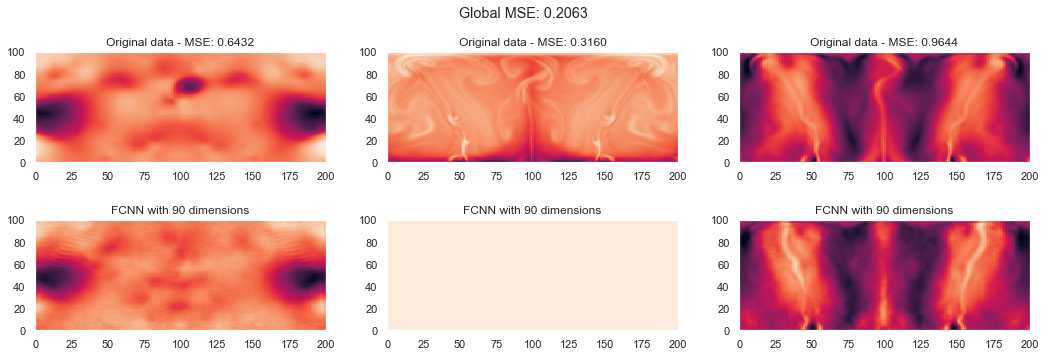

In [24]:
# Case
i = 633
# Get predicted
pred = fcnn_rec[fcnn_idx[i]]
# Get output data
real = dt[i]
# Plot
plot_red_comp(real, pred, None, 90, fcnn_rec_df['MSE'][0], "FCNN")

### LSTM

In [ ]:
# Reconstruct all data
lstm_rec = reconstruct(lstm.predict(x_data), dt_red)
# Dictionary to convert dataset index to the lstm_rec index
lstm_idx = {idx[0]: i for i, idx in enumerate(lstm_idx)}

In [ ]:
# Calculate the metrics
# Store metrics
lstm_rec_dt = []
lstm_rec_tst = []
# Iterating over each study case
for idx in dt.attrs["idx"]:
    # Iterating over each time step
    for i in range(idx[0], idx[1] - 1):
        if i in lstm_idx.keys():
            mse = np.mean((dt[i] - lstm_rec[lstm_idx[i]])**2)
            loss = loss_norm_error_np(dt[i], lstm_rec[lstm_idx[i]])
            lstm_rec_dt += [[mse, loss]]
            if i in slc_tst[0]:
                lstm_rec_tst += [[mse, loss]]

# Convert to numpy array
lstm_rec_dt = np.array(lstm_rec_dt)
lstm_rec_tst = np.array(lstm_rec_tst)

In [ ]:
# Display the results
index = ["Entire dataset", "Test dataset"]
columns = ["MSE", "Loss"]
lstm_rec_df = pd.DataFrame([lstm_rec_dt.mean(axis=0), lstm_rec_tst.mean(axis=0)], index=index, columns=columns)
lstm_rec_df

Similarly to the FCNN, the MSE and loss values obtained after the reconstruction are smaller than those obtained in the reduced dimension space, but for the loss value of the test dataset.

The visual results are presented below from the test dataset for two different study cases:

In [ ]:
# Case
i = 91
# Get predicted
pred = lstm_rec[lstm_idx[i]]
# Get output data
real = dt[i]
# Plot
plot_red_comp(real, pred, None, 90, fcnn_rec_df['MSE'][0], "LSTM")

# Case
i = 1309
# Get predicted
pred = lstm_rec[lstm_idx[i]]
# Get output data
real = dt[i]
# Plot
plot_red_comp(real, pred, None, 90, fcnn_rec_df['MSE'][0], "LSTM")

From the figure above it is possible to see that the LSTM could somewhat predict the next time step both cases, especially for the second case, where there the spatial variation was lower than the first case.

The visual results are presented below from the test dataset for two different study cases:

In [ ]:
# Case
i = 633
# Get predicted
pred = lstm_rec[lstm_idx[i]]
# Get output data
real = dt[i]
# Plot
plot_red_comp(real, pred, None, 90, fcnn_rec_df['MSE'][0], "LSTM")

The performance from the trained dataset presented a reasonable accuracy despite the high spatial variation of the data.

### Decoder predictor

The decoder predictor has a similar structure from the autoencoder previously trained. The difference is the input that comes from the previously trained decoder and the output, which is the next time step in the study case. Again, a hyperparameter optimisation was performed to find the best decoder architecture.

#### Search space

Architecture hyperparameters range for each layer:
* Number of layers: $l \in [1, 3]$;
* Number of filters: $f \in [4, 128]$;
* Kernel size: $ k = 3, 5$;
* Activation functions: $a =ReLU, \,ELU, \,Hyperbolic\,Tangent, \,Linear$;
* Regularizer: $r \in [10^{-7}, 10^{-3}]$;
* Bottleneck size: $b \in [5, 150]$;

Optimisation hyperparameters range:
* Batch size: $b \in [2, 32]$;
* Learning rate: $r \in [10^{-5}, 10^{-1}]$.

#### Results

The script to build the Decoder in the range present above was developed and it is in the `objective()` function at the [Decoder](./hyperparameter-optimisation/pred_dec_search.py) file.

The best architecture hyperparameters:
* Number of layers: $l = 2$;
* $1^{st} layer$ dense:
    * Number of filters: $f_1 = 29$;
    * Kernel size: $ k_1 = 3$;
    * Activation function: $a_1 = ReLU$;
    * Regularization: $l_1 = 1.359\cdot10^{-4}$
* $2^{nd} layer$ convolutional:
    * Number of filters: $f_2 = 89$;
    * Kernel size: $ k_2 = 3$;
    * Activation function: $a_2 = ELU$;
    * Regularization: $l_2 = 9.789\cdot10^{-6}$
 
The best training hyperparameters:
* Batch size: $b = 17$
* Learning rate: $r = 8.6428\cdot10^{-4}$;

The schematic representation of the architecture is presented below:

In [ ]:
# Load trained model
pdec = load_model(path_model.format(arch_dec))
# Get number of parameters to train
print("Parameters to train: {}".format(pdec.count_params()))
# Generate autoencoder architecture graph
plot_model(pdec, show_layer_names=False, show_shapes=True, dpi=96)

#### Evaluating performance

The best loss obtained during the hyperparameter optimisation was $0.1454$.

In [ ]:
# Evaluate the model against all data
pdec_global_loss = pdec.evaluate(dt_red, dt)
# Reconstruct data
pdec_rec = pdec.predict(dt_red)

In [ ]:
# Split data file to get the test dataset slice
pdec_x = format_data(dt_red, wd=2, cont=True)
_, pdec_y, pdec_idx = format_data(dt, wd=2, get_y=True, cont=True, get_idx=True)
pdec_x = np.squeeze(pdec_x)
# Get a dictionary that converts the indexes
pdec_idx = {j[0]: i for i, j in enumerate(pdec_idx)}

In [ ]:
# Evaluate the model against the test dataset
pdec_test_loss = pdec.evaluate(pdec_x[slc_tst[0]] , pdec_y[slc_tst[0]])

In [ ]:
# Display the results
index = ["Entire dataset", "Test dataset"]
columns = ["MSE", "Loss"]
pdec_rec_df = pd.DataFrame([pdec_global_loss[1:], pdec_test_loss[1:]], index=index, columns=columns)
pdec_rec_df

As we can see, similarly to the FCNN, the performance for the test dataset degraded significantly despite regularising and using early stopping techniques during the hyperparameter optimisation, which reinforces the possibility that there were not enough turbulent cases for the neural network to learn. The output reconstruction will be discussed in the sections below.

In [ ]:
# Case
i = 91
# Get predicted
pred = pdec_rec[pdec_idx[i]]
# Get output data
real = dt[i]
# Plot
plot_red_comp(real, pred, None, 90, pdec_rec_df['MSE'][0], "Decoder")

# Case
i = 1309
# Get predicted
pred = pdec_rec[pdec_idx[i]]
# Get output data
real = dt[i]
# Plot
plot_red_comp(real, pred, None, 90, pdec_rec_df['MSE'][0], "Decoder")

From the figure above it is possible to see that the Decoder Predictor could predict with reasonable accuracy the next time step for both cases.

The visual results are presented below from the test dataset for two different study cases:

In [ ]:
# Case
i = 55
# Get predicted
pred = pdec_rec[pdec_idx[i]]
# Get output data
real = dt[i]
# Plot
plot_red_comp(real, pred, None, 90, pdec_rec_df['MSE'][0], "Decoder")

## Surrogate model